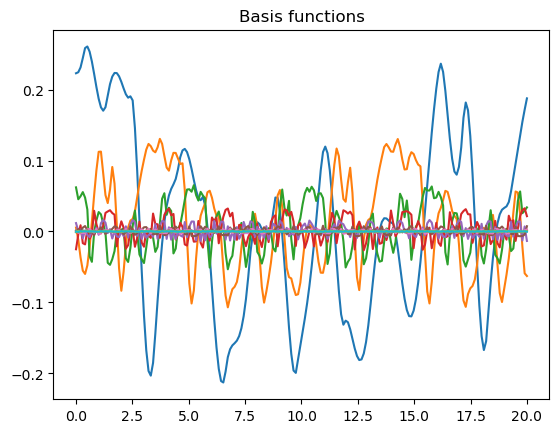

In [86]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

def smoothstep(edge0, edge1, x):
    t = np.clip((x - edge0) / (edge1 - edge0), 0.0, 1.0)
    return t * t * (3 - 2*t)

class GPBasis():
    def __init__(self, l):
        self.thetas = np.random.normal(size=l) # Spectral density of the squared exponential is the normal distribution
        self.taus = np.random.uniform(size=l) * 2 * np.pi # Uniformly distributed as in the paper

    def phi(self, x):
        return np.sqrt(2/len(self.thetas)) * np.cos(self.thetas[None,:] * x[...,None] + self.taus)


class SinWaveBasis():
    def __init__(self, l):
        self.freq = np.linspace(0, 5, l)
        self.phase = np.linspace(0, np.pi*2, l)
        self.amplitude = 1/(2**np.linspace(0, 10, l))

    def phi(self, x):
        return np.sqrt(2/len(self.freq)) * np.sin(self.freq[None,:] * x[...,None] + self.phase)

class PerlinNoiseBasis():

    def cell(self, x):
        interp = (x - self.x_range[0]) / (self.x_range[1] - self.x_range[0])
        cell_pos = interp * (self.random_numbers.shape[0] - 1)
        return np.array(np.floor(cell_pos), dtype=int), cell_pos - np.floor(cell_pos)

    def perlin(self, x):
        cell_x, frac_x = self.cell(x)
        cell_x = (cell_x) % self.random_numbers.shape[0]
        ncell_x = (cell_x+1) % self.random_numbers.shape[0]
        a = self.random_numbers[cell_x, 0]
        b = self.random_numbers[ncell_x, 0]
    
        a_x = self.random_numbers[cell_x, 1]
        b_x = self.random_numbers[ncell_x, 1]
        
        a += a_x*frac_x
        b += b_x*(frac_x-1.0)
        
        return a + (b-a)*smoothstep(0.0,1.0,frac_x) - 0.5

    def __init__(self, l, x_range=(0,20), grid_size=20):
        self.x_range = x_range
        self.random_numbers = np.random.uniform(size=(grid_size, 2))
        self.freq = 2**np.linspace(0, l, l, False)
        self.amplitude = 0.5**(np.linspace(0, l, l, False) + 1)
        self.phase = x_range[0] + np.random.uniform(size=l) * (x_range[1] - x_range[0])


    def phi(self, x):
        return self.perlin(self.freq[None,:] * x[...,None] + self.phase) * self.amplitude / np.sum(self.amplitude)

# Evaluate (6)
def evaluate_basis(x, basis, weights):
    return np.sum(weights[None,...]*basis.phi(x), axis=-1)
    
# Compute mean and covariance of posterior weight distribution (Eq. (7))
def condition(X, y, basis, sigma):
    P = basis.phi(X)
    PtP = P.transpose() @ P
    cm_inv = np.linalg.inv(PtP + sigma**2 * np.identity(PtP.shape[0]))

    mu = cm_inv @ (P.transpose() @ y[...,None])
    Sigma = cm_inv * sigma**2
    return mu.flatten(), Sigma

# Number of basis functions
l = 10

# Setup basis function
#basis = SinWaveBasis(l)
basis = PerlinNoiseBasis(l)
#basis = GPBasis(l)

# Evaluation points for plotting
xs = np.linspace(0, 20, 200)

plt.title("Basis functions")
plt.plot(xs, basis.phi(xs))
plt.show()


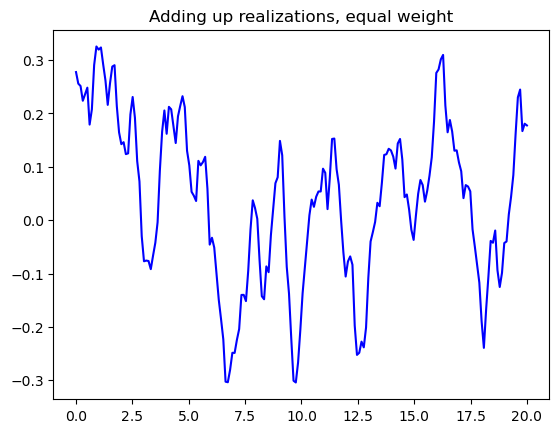

In [87]:

plt.title("Adding up realizations, equal weight")
# Sample and plot 50 realizations
real = evaluate_basis(xs,basis,np.ones(l))
plt.plot(xs, real, color="b")

plt.show()


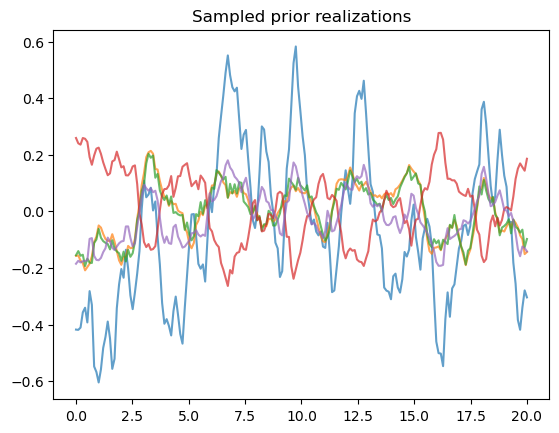

In [90]:

plt.title("Sampled prior realizations")
weights = np.random.normal(size=(5,l))
for w in weights:
    real = evaluate_basis(xs,basis,w)
    plt.plot(xs, real, alpha=0.7)

plt.show()


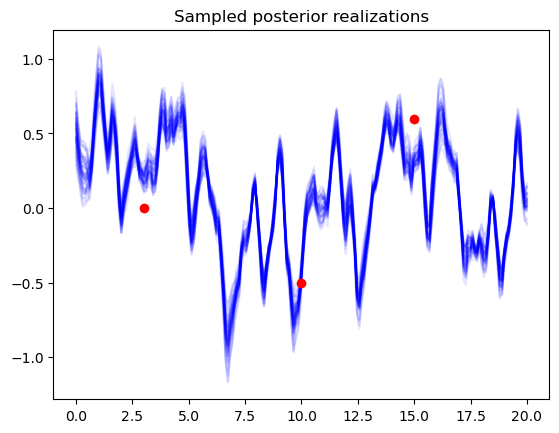

In [89]:

# Condition locations and values
cond_x = np.array([3, 10, 15])
cond_y = np.array([0, -0.5, 0.6])

# Compute posterior weight mean and covariances
cond = condition(cond_x, cond_y, basis, 0.05)
# Define the posterior weight distribution
rv = multivariate_normal(mean=cond[0], cov=cond[1], allow_singular=True)
plt.title("Sampled posterior realizations")
# Sample and plot 50 realizations
weights = rv.rvs(50)
for w in weights:
    real = evaluate_basis(xs,basis,w)
    plt.plot(xs, real, alpha=0.1, color="b")

# Draw conditioning points
plt.scatter(cond_x, cond_y, color="red", zorder=100)
plt.show()